In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from PortfolioToolboxQP.PortfolioToolboxQP.Qp_Solver import qp_solver_cpp as solve

Il faut remplir le code suivant avec ce qu'on a calculé dans les autres fichiers. Faut juste faire attention à ce qu'on est les mêmes colonnes pour tous sinon on va avoir des problèmes de dimensions.

In [3]:
sigma = np.load("data/cov_matrix_sigma.npy")
CI = pd.read_csv("data/CarbonIntensity.csv")
#CI0 = CI["CI_Scope12_FY23"].values.reshape(-1, 1)
CI0 = CI["CARBON_EMISSIONS_SCOPE_12_FY23"].values.reshape(-1, 1)
bench = (CI["Weight"].values / CI["Weight"].sum()).reshape(-1, 1)


J'ai pris le problème le plus simple avec le moins de contrainte (min 1/2(x-b)Tsigma(x-b) avec comme contraintes la carbone intensity, et le bail C0 des long only constraints [x entre 0 et 1 et qui se somme à 1])

x is what we want : here the relative weights on the differents firms. The following Y is what we call "x-b". 
 We have to add the benchmark at the end

                            minimize 0.5*Y.T@Q@Y + p@Y under constraints AY = B and GY <= h and  lb <= Y <= ub
    
    all parameters are ndarray

    Q: sigma for us
    p: 0

    CI*(X=Y+b) <= (1-R)CI_0*b donc CI*Y <= (1-R)*CI_0*b - CI*b
    G: Matrix of inequalty constraints → np.diag(CI0[:,0])
    h: Vector of inequality constraints → (1 - R) * CI0*bench - CI0*bench

    1.T(Y+b)=1 donc 1TY = - 1Tb + 1
    A: Matrix of equality constraints → 1T
    b: Vector of equality constraints → -1Tb + 1
    
    lb: Lower bound for Y : for x : 0
    ub: Upper bound for Y : for x : 1

    return: optimal vector if found : Y=X-b

Calcul du Reduction Rate

In [4]:
def decarbonization_pathway(t0, t, Rm, dR):
    """
    Compute the decarbonization budget with equation (1).

    param t0: base year
    param t: year index
    param Rm: minimum carbon intensity reduction
    param dR: year-to-year self decarbonization on average per annum
    """
    return 1 - (1 - dR) ** (t - t0) * (1 - Rm)

In [73]:
t0, t = 2023, 2050

times = np.arange(t0, t + 1)

# CTB label: Rm=0.3 dR=0.07
ctb_label = decarbonization_pathway(t0, times, 0.3, 0.07)

# PAB label: Rm=0.5 dr=0.07
pab_label = decarbonization_pathway(t0, times, 0.5, 0.07)

x_list = []
te = []
R_ = ctb_label

for year in range(len(R_)):
    R = R_[year]
    ye = 23+year
    print(ye)
    column = "CARBON_EMISSIONS_SCOPE_12_FY"+str(ye)
    CI_year = CI[column].values.reshape(-1, 1)
    CI_year[CI_year < 0] = 0
    y = solve(
        Q = sigma,
        p = None,
        G = np.diag(CI_year[:,0]),
        h = (1 - R) * CI0 * bench - CI_year * bench,
        A = np.ones((bench.shape[0],1)).T,
        b =-np.ones(bench.shape).T @ bench + 1,
        lb = - bench,
        ub =np.ones(bench.shape) - bench,
    )
    y = y[:,np.newaxis]
    x = y + bench
    x_list.append(x)
    name_col = "Weight_FY"+str(ye)
    CI[name_col] = x
    tracking_error = 0.5 * y.T @ sigma @ y
    te.append(tracking_error)

23


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [74]:
print(te)

[array([[1.52097936e-06]]), array([[6.92526446e-07]]), array([[6.82063376e-07]]), array([[7.9093258e-07]]), array([[9.19681585e-07]]), array([[1.04553486e-06]]), array([[1.15071618e-06]]), array([[1.25622863e-06]]), array([[1.35183127e-06]]), array([[1.44031997e-06]]), array([[1.52464923e-06]]), array([[1.60056272e-06]]), array([[1.66778214e-06]]), array([[1.72682731e-06]]), array([[1.77959732e-06]]), array([[1.83020781e-06]]), array([[1.8792511e-06]]), array([[1.92431398e-06]]), array([[1.96481955e-06]]), array([[2.00180595e-06]]), array([[2.03506915e-06]]), array([[2.0637956e-06]]), array([[2.09127866e-06]]), array([[2.11647542e-06]]), array([[2.13898014e-06]]), array([[2.158128e-06]]), array([[2.17493833e-06]]), array([[2.19089239e-06]])]


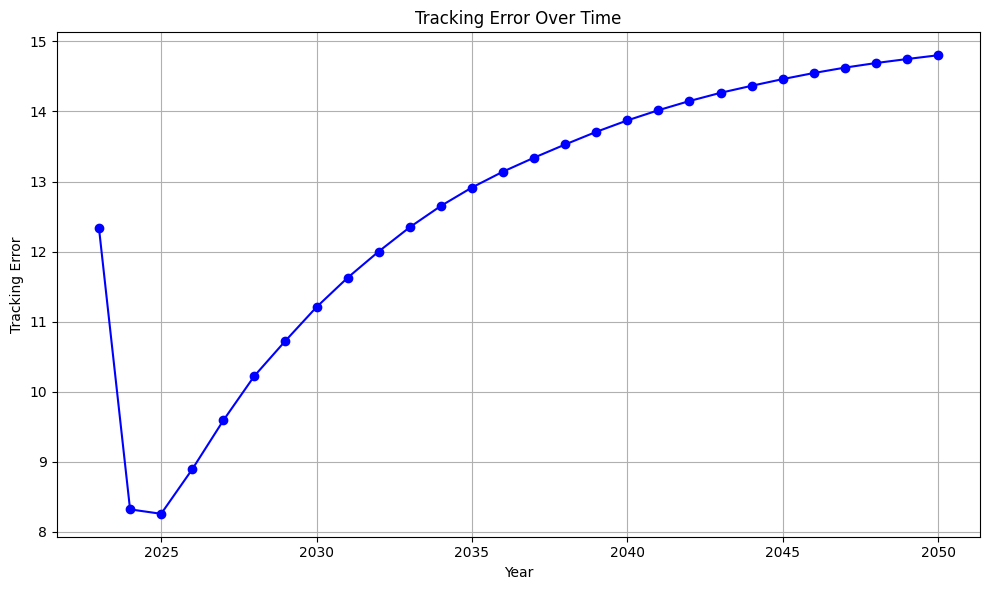

In [75]:
# Convert the list of tracking errors to a numpy array for easier manipulation
te_array = [np.sqrt(te[i][0][0])*1e4 for i in range(len(te))]

# Plot the tracking error over time
plt.figure(figsize=(10, 6))
plt.plot(times, te_array, marker='o', linestyle='-', color='b')
plt.title('Tracking Error Over Time')
plt.xlabel('Year')
plt.ylabel('Tracking Error')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
R_list = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975]
column = "CARBON_EMISSIONS_SCOPE_12_FY23"
CI0[CI0 < 0] = 0
te_graphe = []
for year in range(len(R_list)):
    R = R_list[year]
    ye = 23+year
    print(year)
    y = solve(
        Q = sigma,
        p = None,
        G = np.diag(CI0[:,0]),
        h = (1 - R) * CI0 * bench - CI0 * bench,
        A = np.ones((bench.shape[0],1)).T,
        b =-np.ones(bench.shape).T @ bench + 1,
        lb = - bench,
        ub =np.ones(bench.shape) - bench,
    )
    tracking_error = 0.5 * y.T @ sigma @ y
    te_graphe.append(tracking_error)

0


c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:137: UserWarning: Warning : The p matrix in the QP problem was set to 0 as it was either empty or None -- Continuing optimization !
  warnings.warn(
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:189: UserWarning: Warning : b was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : b was reshaped as its shape was not of form (n,)")
c:\Users\vahye\Desktop\ENSAE\projet_finance\net-zero-portfolio\PortfolioToolboxQP\PortfolioToolboxQP\Qp_Solver.py:202: UserWarning: Warning : h was reshaped as its shape was not of form (n,)
  warnings.warn("Warning : h was reshaped as its shape was not of form (n,)")


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


(26,)


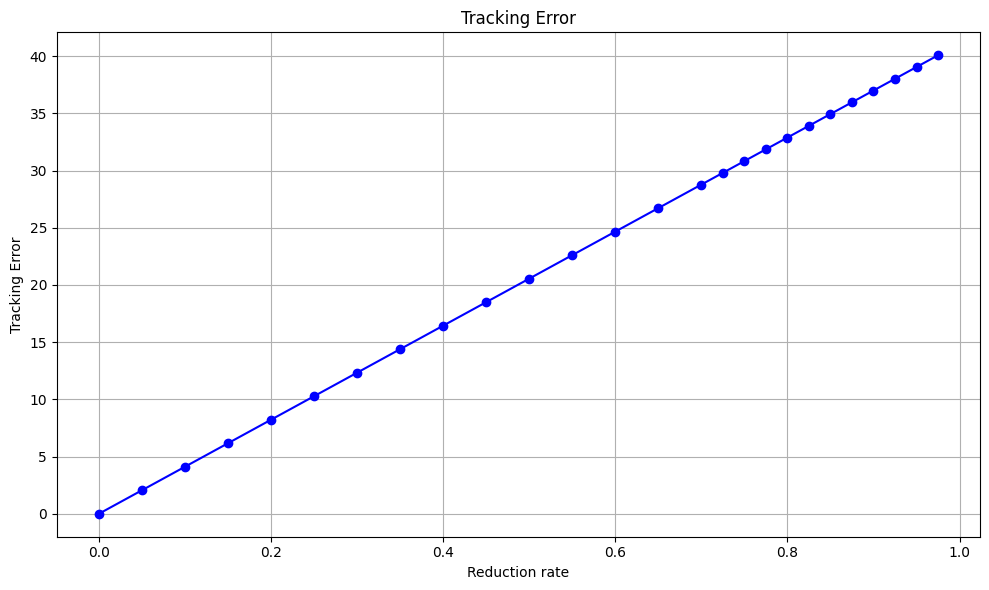

In [36]:
te_gr = np.array(te_graphe)
te_gr = [np.sqrt(te_gr[i])*1e4 for i in range(len(te_gr))]
R_list = np.array(R_list)
print(R_list.shape)

plt.figure(figsize=(10, 6))
plt.plot(R_list, te_gr, marker='o', linestyle='-', color='b')
plt.title('Tracking Error')
plt.xlabel('Reduction rate')
plt.ylabel('Tracking Error')
plt.grid(True)
plt.tight_layout()
plt.show()

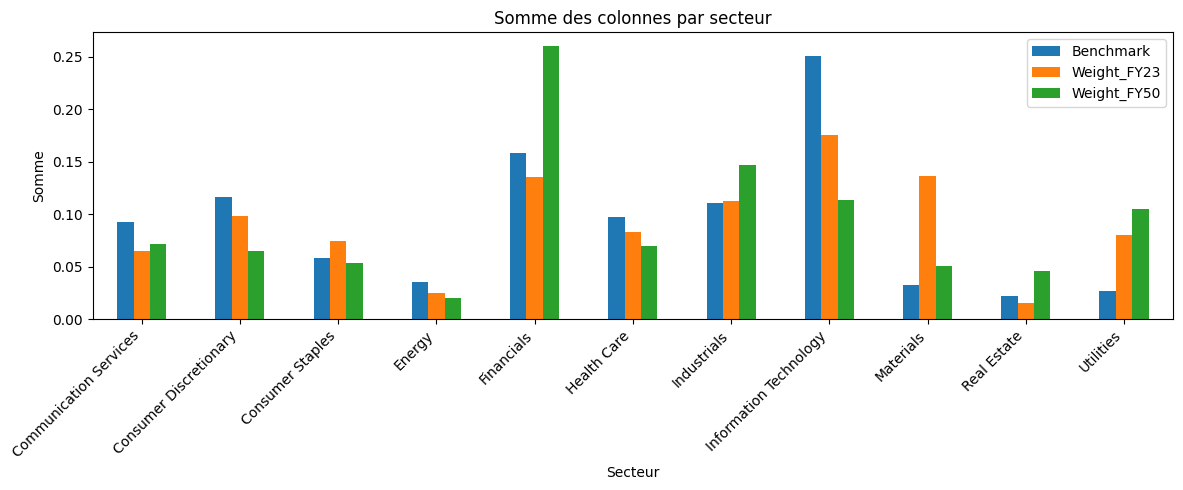

In [6]:
CI["benchmark"] = bench
grouped = CI.groupby("GICS_SECTOR")[[ "benchmark","Weight_FY23","Weight_FY50"]].sum()

# Tracer l'histogramme
grouped.plot(
    kind="bar",
    figsize=(12, 5),
    stacked=False,  # Changez en True pour un histogramme empilé
)
plt.title("Somme des colonnes par secteur")
plt.xlabel("Secteur")
plt.ylabel("Somme")
plt.xticks(rotation=45, ha="right")  # Rotation des étiquettes pour lisibilité
plt.legend(["Benchmark","Weight_FY23", "Weight_FY50"], loc="upper right")  # Légende personnalisée
plt.tight_layout()
plt.show()

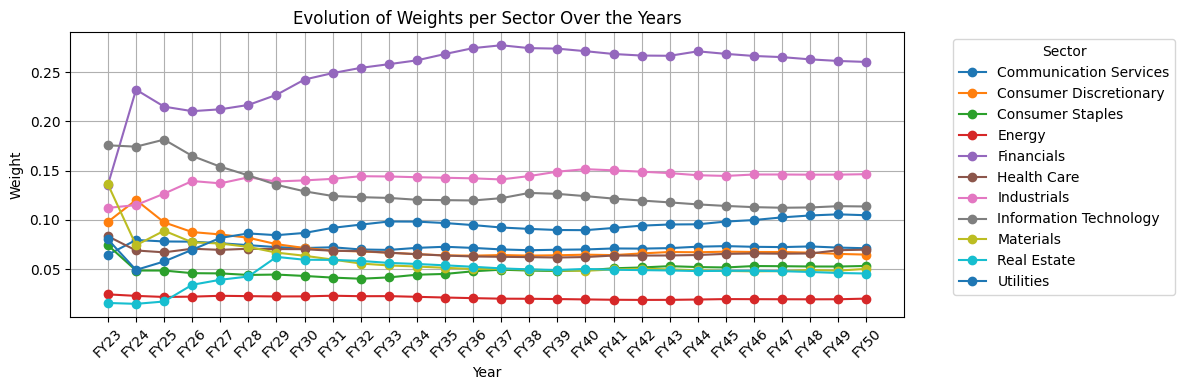

In [7]:
# Extract the columns related to weights over the years
weight_columns = [col for col in CI.columns if col.startswith('Weight_FY')]

# Group by sector and sum the weights for each year
sector_weights = CI.groupby('GICS_SECTOR')[weight_columns].sum()

# Plot the evolution of weights per sector over the years
sector_weights.T.plot(figsize=(12, 4), marker='o')
plt.title('Evolution of Weights per Sector Over the Years')
plt.xlabel('Year')
plt.ylabel('Weight')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=range(len(weight_columns)), labels=[col.split('_')[-1] for col in weight_columns], rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

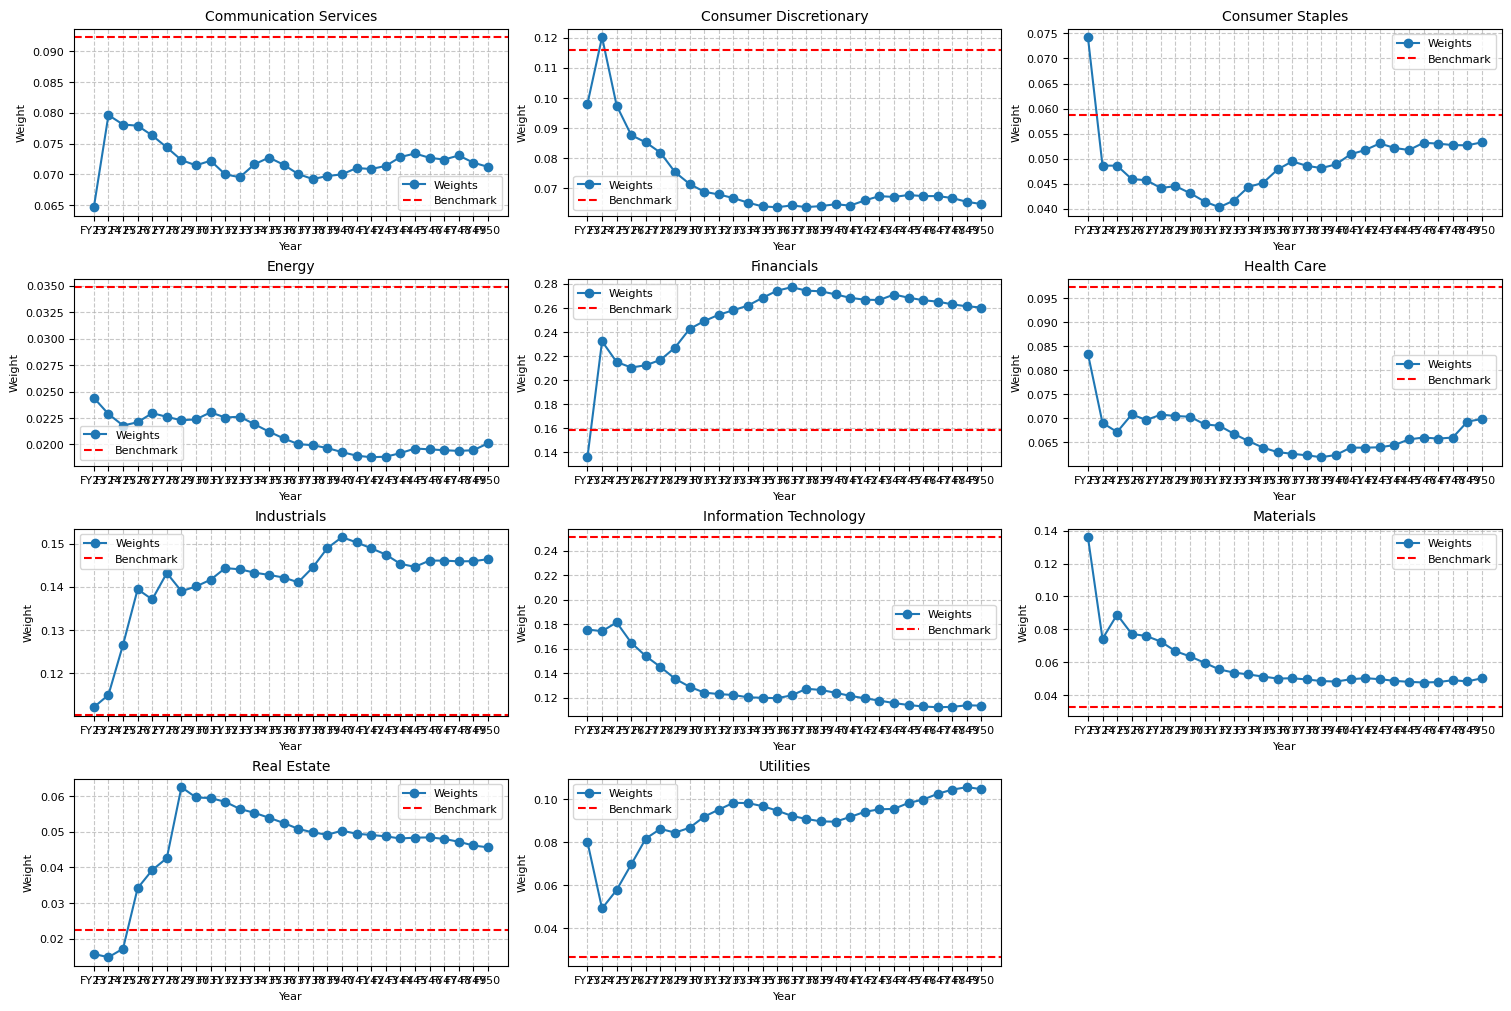

In [8]:
import math

# Extract the columns related to weights over the years
weight_columns = [col for col in CI.columns if col.startswith('Weight_FY')] 

# Group by sector and sum the weights for each year
sector_weights = CI.groupby('GICS_SECTOR')[weight_columns].sum()
benchmark_val = CI.groupby('GICS_SECTOR')["benchmark"].sum()

# Number of sectors
num_sectors = len(sector_weights.index)

# Define the number of columns for subplots (e.g., 3 columns per row)
cols = 3
rows = math.ceil(num_sectors / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot for each sector
for i, sector in enumerate(sector_weights.index):
    ax = axes[i]
    
    # Plot the weights over the years for the current sector
    ax.plot(
        [col.split('_')[-1] for col in weight_columns],  # Extract years from column names
        sector_weights.loc[sector],
        marker='o',
        label='Weights'
    )
    
    # Add a horizontal line for the benchmark value of the current sector
    ax.axhline(
        y=benchmark_val.loc[sector], 
        color='r', 
        linestyle='--', 
        label='Benchmark'
    )
    
    # Titles and labels
    ax.set_title(sector, fontsize=10)
    ax.set_xlabel('Year', fontsize=8)
    ax.set_ylabel('Weight', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend(fontsize=8)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()


A utiliser uniquement si on a des contraintes qui excluent des entreprises (CM, greenness...)

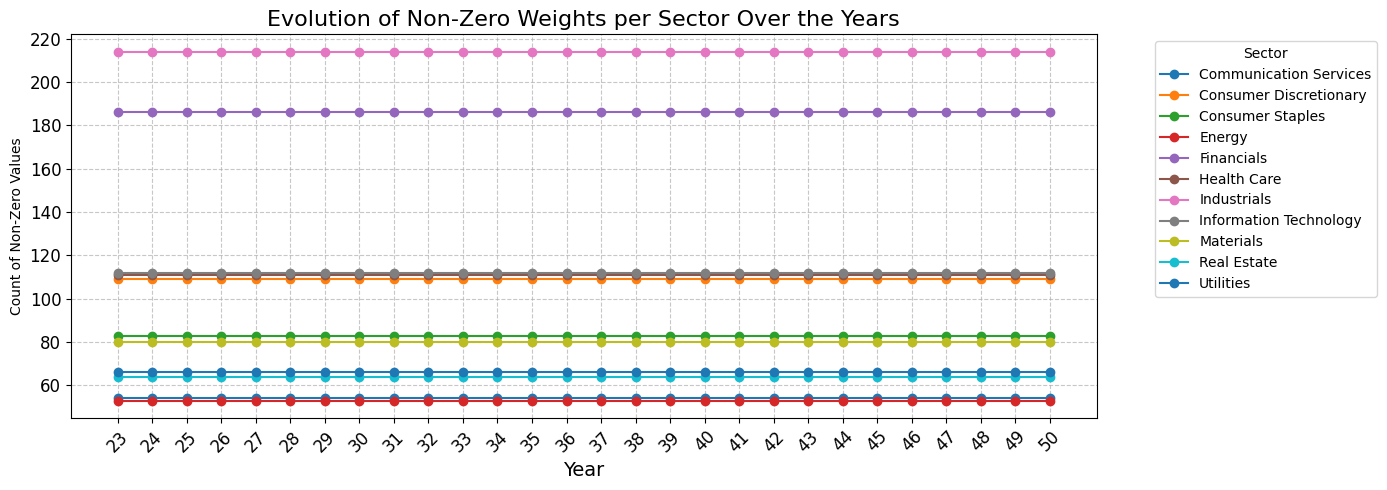

In [9]:
# Extraire les colonnes liées aux poids au fil des années
weight_columns = [col for col in CI.columns if col.startswith('Weight_FY')]

# Ajouter des colonnes "zero_" indiquant si les valeurs sont significativement différentes de zéro
for i, col in enumerate(weight_columns):
    CI[f"zero_{23 + i}"] = CI[col] > 0.000001  # Ajuster l'index des années (par exemple, FY23 = 2023)

# Sélectionner les colonnes "zero_" pour le comptage
zero_columns = [col for col in CI.columns if col.startswith('zero_')]

# Grouper par secteur et compter les valeurs "True" pour chaque année
non_zero_counts = CI.groupby('GICS_SECTOR')[zero_columns].sum()

# Transposer pour visualiser les années sur l'axe X
non_zero_counts.T.plot(figsize=(14, 5), marker='o')

# Ajouter des titres, labels et personnalisation
plt.title('Evolution of Non-Zero Weights per Sector Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count of Non-Zero Values')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(
    ticks=range(len(zero_columns)), 
    labels=[col.split('_')[-1] for col in zero_columns], 
    rotation=45, 
    fontsize=12
)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


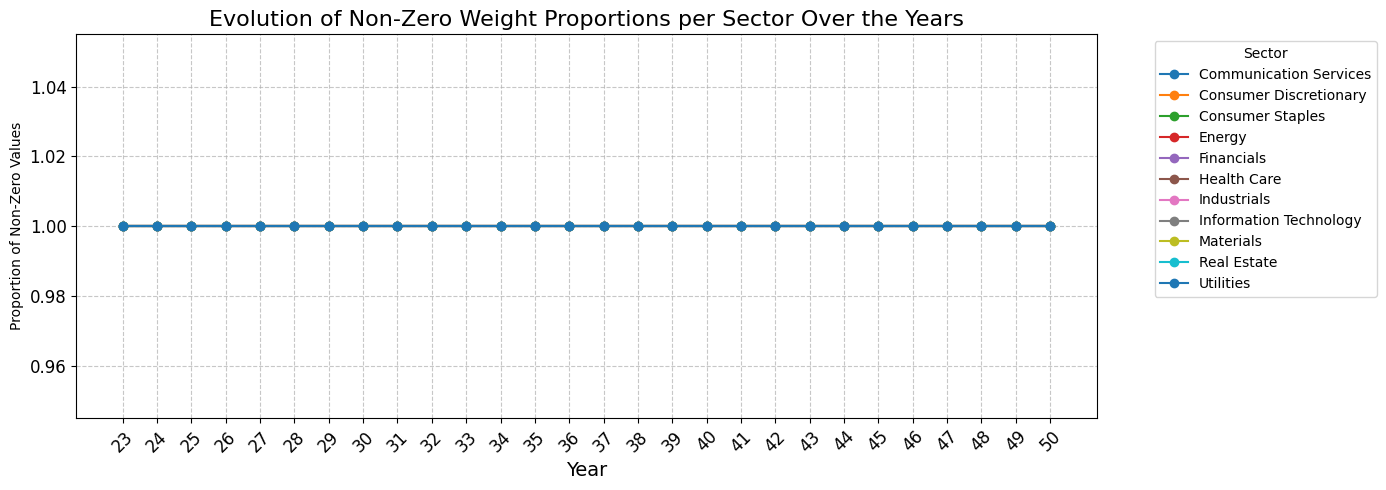

In [10]:
# Extraire les colonnes liées aux poids au fil des années
weight_columns = [col for col in CI.columns if col.startswith('Weight_FY')]

# Ajouter des colonnes "zero_" indiquant si les valeurs sont significativement différentes de zéro
for i, col in enumerate(weight_columns):
    CI[f"zero_{23 + i}"] = CI[col] > 0.000001  # Ajuster l'index des années (par exemple, FY23 = 2023)

# Sélectionner les colonnes "zero_" pour le comptage
zero_columns = [col for col in CI.columns if col.startswith('zero_')]

# Grouper par secteur et compter les valeurs "True" pour chaque année
sector_counts = CI.groupby('GICS_SECTOR')[zero_columns].sum()

# Calculer le nombre total de lignes par secteur
sector_totals = CI.groupby('GICS_SECTOR').size()

# Diviser chaque somme par le nombre de lignes du secteur pour obtenir les parts
sector_proportions = sector_counts.div(sector_totals, axis=0)

# Transposer pour visualiser les années sur l'axe X
sector_proportions.T.plot(figsize=(14, 5), marker='o')

# Ajouter des titres, labels et personnalisation
plt.title('Evolution of Non-Zero Weight Proportions per Sector Over the Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Proportion of Non-Zero Values')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(
    ticks=range(len(zero_columns)), 
    labels=[col.split('_')[-1] for col in zero_columns], 
    rotation=45, 
    fontsize=12
)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
